In [1]:
import pandas as pd
df=pd.read_csv("amazon.csv")

In [2]:
df=df[['Date','Close']]
df['Date']

0       1997-05-15
1       1997-05-16
2       1997-05-19
3       1997-05-20
4       1997-05-21
           ...    
6757    2024-03-22
6758    2024-03-25
6759    2024-03-26
6760    2024-03-27
6761    2024-03-28
Name: Date, Length: 6762, dtype: object

In [3]:
df['Date']

0       1997-05-15
1       1997-05-16
2       1997-05-19
3       1997-05-20
4       1997-05-21
           ...    
6757    2024-03-22
6758    2024-03-25
6759    2024-03-26
6760    2024-03-27
6761    2024-03-28
Name: Date, Length: 6762, dtype: object

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6757,2024-03-22,178.869995
6758,2024-03-25,179.710007
6759,2024-03-26,178.300003
6760,2024-03-27,179.830002


In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1997-05-15
1      1997-05-16
2      1997-05-19
3      1997-05-20
4      1997-05-21
          ...    
6757   2024-03-22
6758   2024-03-25
6759   2024-03-26
6760   2024-03-27
6761   2024-03-28
Name: Date, Length: 6762, dtype: datetime64[ns]

In [7]:
df.index = df.pop('Date')
df

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354
...,...
2024-03-22,178.869995
2024-03-25,179.710007
2024-03-26,178.300003


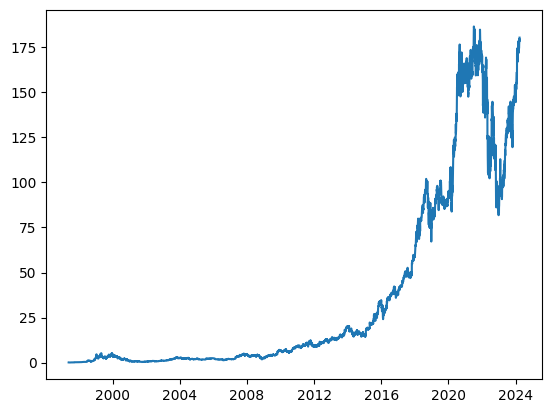

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2020-05-20', 
                                '2024-03-28', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-05-20,120.488998,121.313004,122.466499,124.897003
1,2020-05-21,121.313004,122.466499,124.897003,122.336998
2,2020-05-22,122.466499,124.897003,122.336998,121.844002
3,2020-05-26,124.897003,122.336998,121.844002,121.093002
4,2020-05-27,122.336998,121.844002,121.093002,120.519501
...,...,...,...,...,...
966,2024-03-22,175.899994,178.149994,178.149994,178.869995
967,2024-03-25,178.149994,178.149994,178.869995,179.710007
968,2024-03-26,178.149994,178.869995,179.710007,178.300003
969,2024-03-27,178.869995,179.710007,178.300003,179.830002


In [10]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((971,), (971, 3, 1), (971,))

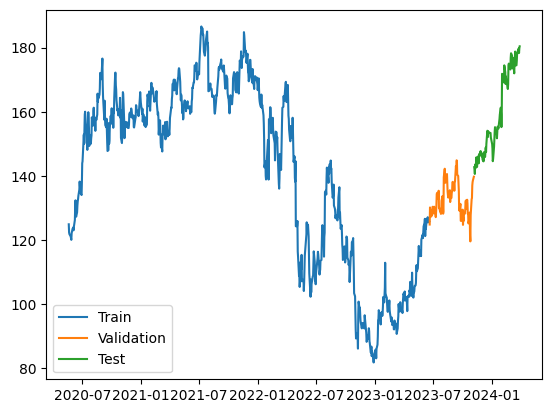

In [11]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 20395.5469 - mean_absolute_error: 139.9657 - val_loss: 17656.7461 - val_mean_absolute_error: 130.9949
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20099.1367 - mean_absolute_error: 138.9793 - val_loss: 16756.8535 - val_mean_absolute_error: 127.5578
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19245.8262 - mean_absolute_error: 135.7394 - val_loss: 13450.8662 - val_mean_absolute_error: 114.0554
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14372.9258 - mean_absolute_error: 116.3067 - val_loss: 7620.7466 - val_mean_absolute_error: 85.3480
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8188.0684 - mean_absolute_error: 85.2125 - val_loss: 1796.2031 - val_mean_absolute_error: 40.2037
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2250.7407 - mean_absolute_error: 40.5704 - val_loss: 58.6985 - val_mean_absolute_error: 7.5808
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


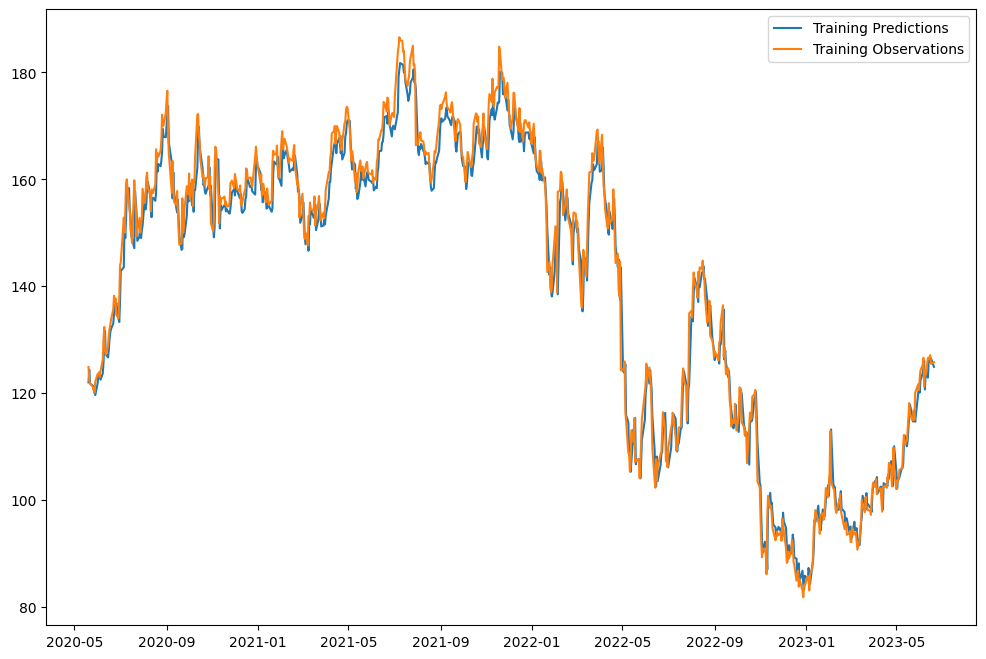

In [13]:
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(12, 8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [1]:
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(12, 8))

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

NameError: name 'model' is not defined

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


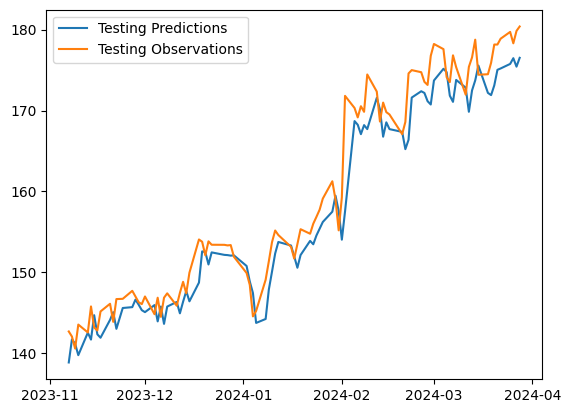

In [16]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

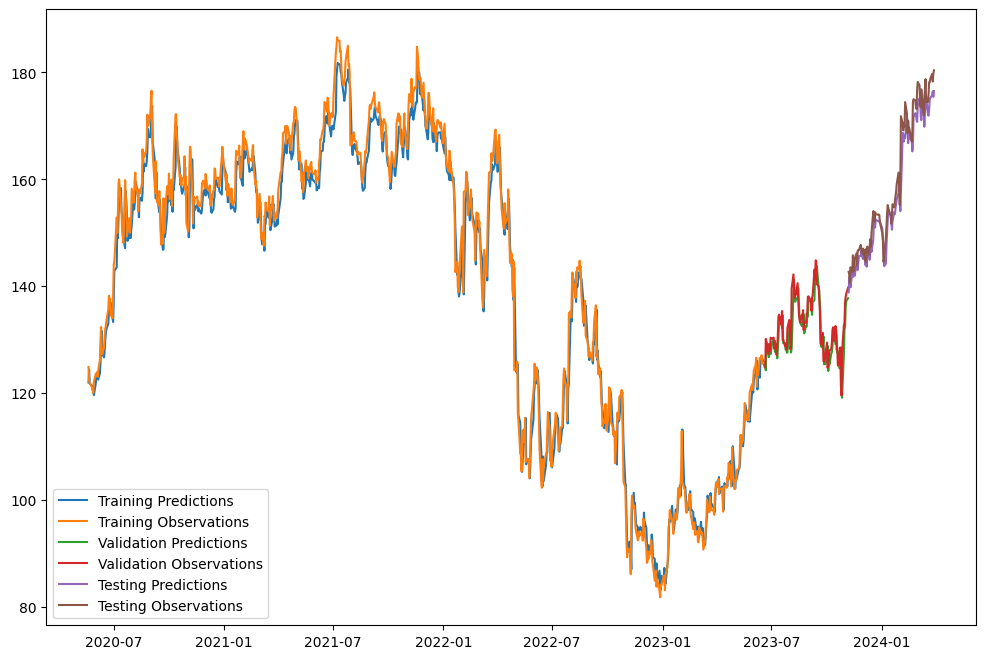

In [17]:
plt.figure(figsize=(12, 8))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [18]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

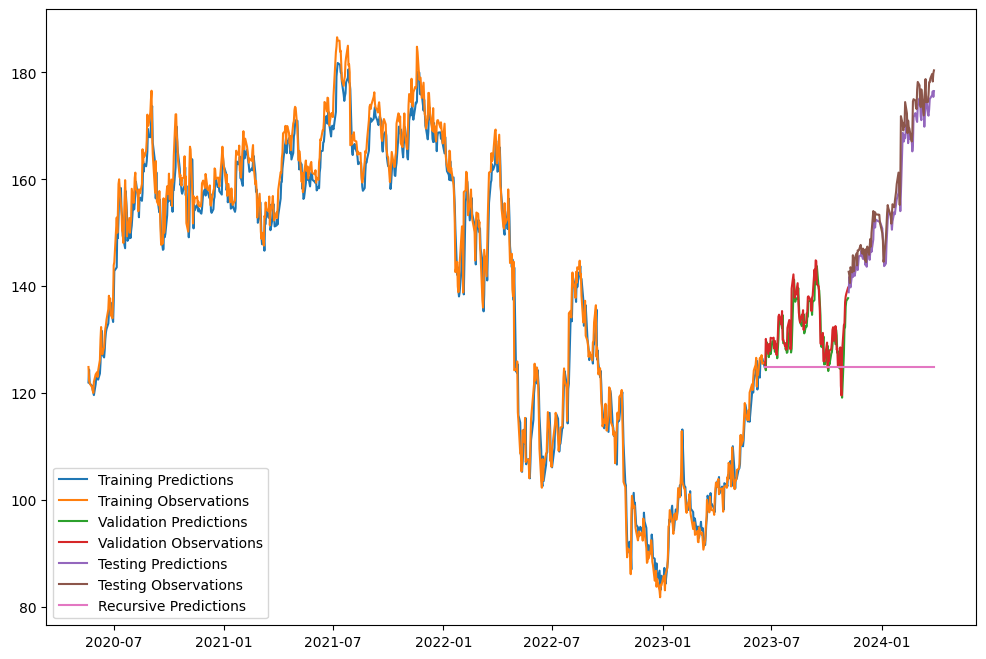

In [19]:
plt.figure(figsize=(12, 8))


plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])